In [31]:
import random
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cuda


In [32]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [33]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [48]:
class DQN:
  # initialize values
  def __init__(self, N, env):
    # initialize environment
    self.env = env
    state, info = self.env.reset()
    # initialize replay memory to capacity N
    self.replay = ReplayMemory(N)
    self.pointer = 0
    self.policy_net = Net(len(state), self.env.action_space.n).to(device)
    self.target_net = Net(len(state), self.env.action_space.n).to(device)

    self.optimizer = optim.SGD(self.policy_net.parameters(), lr=0.01)



  
  # Main training function
  def train(self, episodes, epsilon, discount, action_function, greedy):
    total_reward = [0] * episodes  
    TAU = .0004
    for i in range(episodes):
      # initialize sequence S and preprocessed sequence o
      seq  = [None , None]
      state, info = self.env.reset()
      seq[0] = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      done = False
      rewards = 0
      eps = epsilon ** i if not greedy else 0
      while not done:
        # Select action
        action_type = action_function(seq[0], eps)
        observation, reward, terminated, truncated, _ = self.env.step(action_type.item())
        state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
        # Set sequence
        seq[1] = state       
        rewards += reward
        reward = torch.tensor([reward], device=device)
        # store transition in replay buffer
        self.replay.push(seq[0], action_type,  seq[1], reward)
        seq[0] = state
        
        self.optimize_function(discount)

        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]* TAU + target_net_state_dict[key]*(1- TAU)
        

        self.target_net.load_state_dict(target_net_state_dict)
        done = truncated or terminated
      # Decay epsilon after every episode
      epsilon *= epsilon
      total_reward[i] = rewards  
    return total_reward
  # Determine the action for the warehouse environment
      
  def mountain_car_action(self, state, epsilon):
    if np.random.rand() < epsilon:
        action_type = self.env.action_space.sample()
    else:
        # select max(Q)
        with torch.no_grad():
            return self.policy_net(state).max(1).indices.view(1, 1) 
    return torch.tensor([[action_type]], device=device, dtype=torch.long)
  
  def optimize_function(self, discount):
    BATCH_SIZE = 128
    if len(self.replay) < BATCH_SIZE:
        return
    else:
        transitions = self.replay.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * discount) + reward_batch
             
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
  # Save the current weights
  def save(self, filename):
    with open("pickles/" + filename, 'wb') as file:
      pickle.dump(self.policy_net, file)


In [53]:
#Prints the reward per epsisode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - int(min(reward_per_episode)) * (.15)
    maxs = int(max(reward_per_episode)) + int(max(reward_per_episode)) * (.3) 
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()


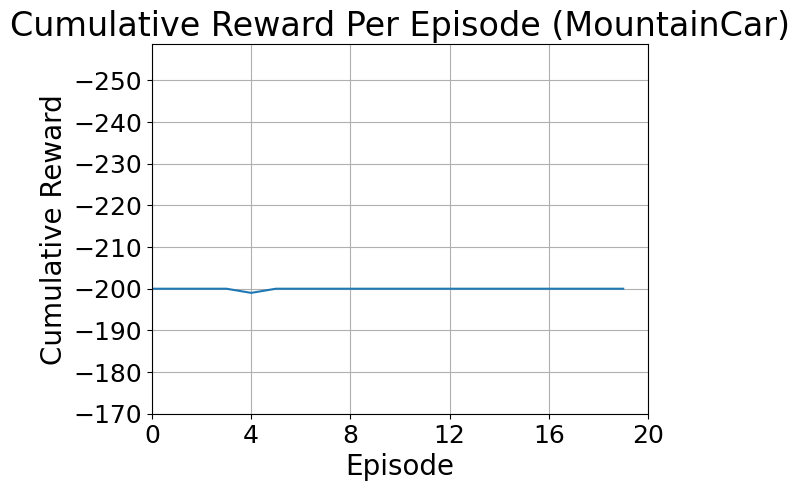

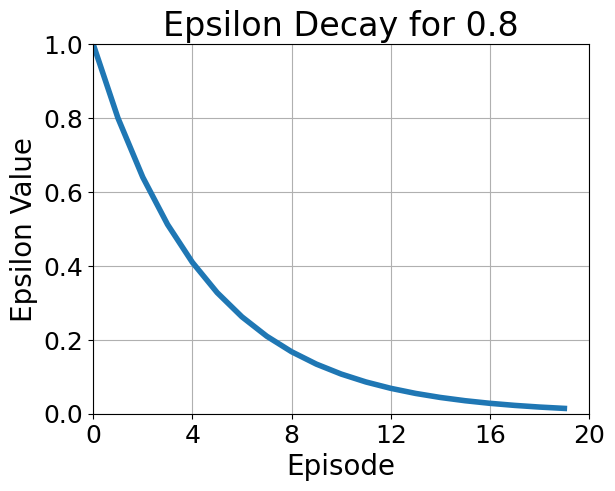

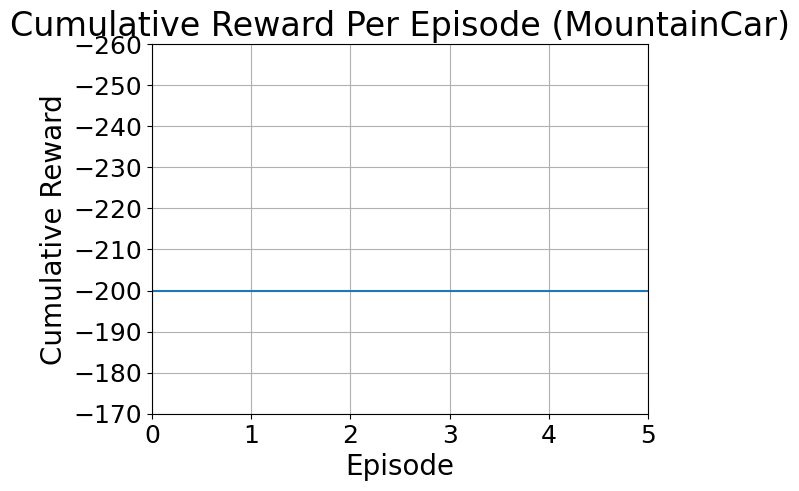

In [57]:
N = 5000
env = gym.make("MountainCar-v0")
env.reset()
MtnCar = DQN(N, env)

episodes = 20
epsilon = .8
discount = .4
action = MtnCar.mountain_car_action
total_rewards = MtnCar.train(episodes, epsilon, discount, action, False)
MtnCar.save("drpreisl_angustsa_assignment2_part2_dqn_mountaincar.pickle")
reward_print(total_rewards, episodes, "MountainCar")
ep_decay(epsilon, episodes)
total_rewards = MtnCar.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "MountainCar")

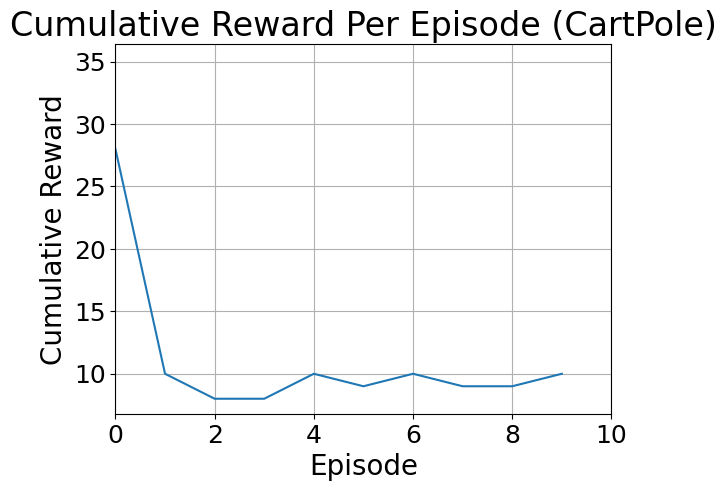

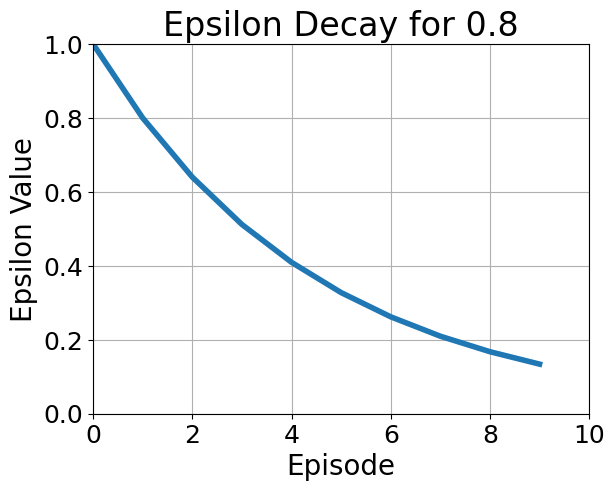

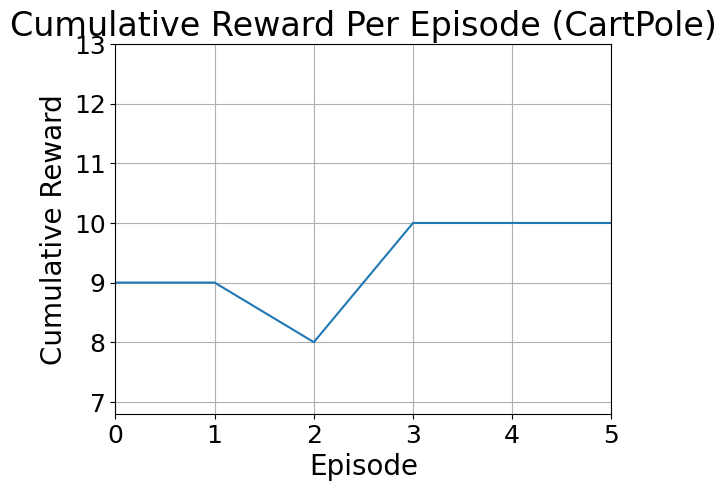

In [56]:
N = 5000
env = gym.make("CartPole-v1")
env.reset()
cart = DQN(N, env)

episodes = 10
epsilon = .8
discount = .4
action = cart.mountain_car_action
total_rewards = cart.train(episodes, epsilon, discount, action, False)
cart.save("drpreisl_angustsa_assignment2_part2_dqn_cartpole.pickle")
reward_print(total_rewards, episodes, "CartPole")
ep_decay(epsilon, episodes)
total_rewards = cart.train(6, epsilon, discount, action, True)
reward_print(total_rewards, 5, "CartPole")